In [1]:
import dos
from IPython.display import Image
path = './dos/Cmatrix_dcGain_AllResiduals'

In [ ]:
# init
sim = dos.DOS(path, 20, show_timing = 2)
Image(filename=path + '/timing.png')

INFO:DOS:Reading config from ./dos/Cmatrix_dcGain_AllResiduals/dos.yaml


In [ ]:
sim.start()

In [ ]:
sim.join()
sim.terminate()

logs = sim.logs.entries

# plot logs
---

#####  Save

---

In [ ]:
# Genarate and save displacements

import scipy.io as sio
import yaml
import numpy as np

duration = sim.cfg['simulation']['duration']

with open(path + r'/FEM.yaml') as file:
    cfg = yaml.load(file, Loader=yaml.FullLoader)
    
fem_io = cfg['FEM']['build']['fem_io_filename']
fem_ss = cfg['FEM']['build']['state_space_filename']

shape_st_ = (C.shape[1],duration*2000+1)
states = np.memmap('./variables/states.dat', dtype=np.float32, mode='r+', shape=shape_st_)

C = sio.loadmat(fem_ss)['C']

data = sio.loadmat(fem_io)
fem_outputs=[(x[0][0],y[0]) for x,y in zip(data['FEM_IO']['outputs_name'][0,0],
                                           data['FEM_IO']['outputs_size'][0][0])]

i_sum = 0
i_, ii_ = 0, 0
for k in fem_outputs:
    if k[0] != 'M1_surfaces_d':
        i_sum += k[1]
    else:
        ref_size = k[1]
        i_, ii_ = i_sum, i_sum + ref_size
C = C[i_:ii_,:]
indexes = range(2,C.shape[0],3)
C = C[indexes, :]

displacements_ptt = np.dot(C, states)

indc1 = [x*742 for x in range(1,7)]
seg_displacements_ptt = np.array(np.split(displacements_ptt,
                                 indices_or_sections = indc1,
                                 axis = 0), dtype = object)

seg_BM = np.empty([7], dtype = object)

for seg in range(7):
    _STR = 'Bending Modes S' + str(seg + 1)
    seg_BM[seg] =  logs['FEM'][_STR].timeSeries[1].T

In [ ]:
import pickle

with open('./logs/displacements_ptt_dcGain_allResiduals.sclogs', 'wb') as f:
    pickle.dump({'displacements_ptt':seg_displacements_ptt}, f)
    
with open('./logs/bending_modes_dcGain_allResiduals.sclogs', 'wb') as f:
    pickle.dump({'bending_modes': seg_BM}, f)

##### Load

---

In [ ]:
import pickle
import numpy as np
import scipy.io as sio
import yaml

displacements_ptt = pickle.load( open( './logs/displacements_ptt_dcGain_allResiduals.sclogs',
                                       "rb" ) )['displacements_ptt']

bending_modes = pickle.load( open( './logs/bending_modes_dcGain_allResiduals.sclogs',
                                   "rb" ) )['bending_modes']

#### Be sure to use the right transformation matrix!

In [ ]:
transformation_path = '../database/bendingmodes/AllResidualSoftDrive_SSMode_transformation_matrices.mat'
Q_seg = np.squeeze(sio.loadmat(transformation_path)['Q_incell'])
U_seg = np.squeeze(sio.loadmat(transformation_path)['U_incell'])

In [ ]:
import matplotlib.pyplot as plt
try:
    from jupyterthemes import jtplot
    jtplot.style()
except:
    pass

duration = (bending_modes[0].shape[1] - 1)/2000 
xticks = np.arange(0, duration + 1, duration/ 10)

#### Surface displacement

In [ ]:
# Plot Bending Modes

seg = 6

plt.figure(figsize = (12,7))
plt.plot(bending_modes[seg][:,:].T)
plt.show()

In [ ]:
def remove_ptt_time(seg_displacements_ptt, Q, vartype = np.float64):
    n_samples = seg_displacements_ptt.shape[1]
    n_nodes = seg_displacements_ptt.shape[0]

    displacements_noptt_ = np.empty([n_nodes, n_samples], dtype=vartype)
    ptt = np.empty([n_nodes, n_samples], dtype=vartype)
    
    for k in range(displacements_noptt_.shape[1]):
        _aux = np.linalg.lstsq(Q, seg_displacements_ptt[:,k])[0]
        ptt[:,k] = np.dot(Q, _aux)
        displacements_noptt_[:,k] = seg_displacements_ptt[:,k] - ptt[:,k]
    return displacements_noptt_, ptt

def disp_to_bm(disp_noPTT, U):
    U64 = np.empty(U.shape, dtype=np.float64)
    disp_noPTT64 = np.empty(disp_noPTT.shape, dtype=np.float64)
    
    U64[:] = U[:]
    disp_noPTT64[:] = disp_noPTT[:]
    
    return np.dot(U64.T, disp_noPTT64) # returns bm

def bm_to_disp(bm, U):
    return np.dot(U, bm) 

def return_surface(displacements ,Ts, Q , zmin, zmax, ax = None, fig = None):
    
    import matplotlib.pyplot as plt
    import matplotlib.tri as mtri   
    import matplotlib.animation as animation
    import matplotlib as mpl
    import scipy.spatial as ssp
    
    if ax is None:
        ax = plt.gca()
        
    resolution = 100
    
    tri = ssp.Delaunay(Q[:,[0,1]])

    xi = Q[:,0]
    yi = Q[:,1]
    
    z = displacements[:,Ts]

    triang = mtri.Triangulation(xi, yi, tri.simplices.copy())
    
    z_values = z

    interp_cubic_geom = mtri.CubicTriInterpolator(triang, z_values, kind='geom')
    xi = np.linspace(xi.min(), xi.max(), resolution)
    yi = np.linspace(yi.min(), yi.max(), resolution)
    xii, yii = np.meshgrid(xi, yi)
    zi_cubic_geom = interp_cubic_geom(xii, yii)

    z_min, z_max = z.min(), z.max()
    
    graph = ax.contourf(xii, yii, zi_cubic_geom, vmin = zmin, vmax = zmax)
    return graph

In [ ]:
ptt = np.empty((7,), dtype = object)
disp_noPTT = np.empty((7,), dtype = object)

for seg in range(7):
    disp_noPTT[seg], ptt[seg] = remove_ptt_time(displacements_ptt[seg],
                                                Q_seg[seg],
                                               vartype = np.float64)

In [ ]:
bending_modes[0].shape

In [ ]:
rec_disp = np.empty((7,), dtype = object)

for seg in range(7):
    rec_disp[seg] = bm_to_disp(bending_modes[seg][0:30,:], U_seg[seg][:,0:30])

In [ ]:
Ts  = 20000
seg = 2

Q_ = Q_seg[seg]

fig, axes =  plt.subplots(1 ,3 ,figsize = (30, 12))
ax1, ax2, ax3 = axes

z_max = np.amax(rec_disp[seg])
z_min = np.amin(rec_disp[seg])
z_step = (z_max - z_min)/10

error = disp_noPTT[seg] - rec_disp[seg]
e_max = np.amax(error)
e_min = np.amin(error)

graph1 = return_surface(rec_disp[seg], Ts,  Q_, z_min, z_max, ax1, fig)
graph2 = return_surface(rec_disp[seg], Ts,  Q_, z_min, z_max,  ax2, fig)
graph3 = return_surface(error, Ts, Q_, e_min, e_max,  ax3, fig);

cbar1 = fig.colorbar(graph1, ax = [ax1, ax2], orientation='horizontal', aspect=20)
cbar2 = fig.colorbar(graph3, ax=[ax3], orientation='horizontal', aspect=9)

In [ ]:
"""
Check error magnitude when removing ptt from displacement and adding it again
"""

seg = 0
node = 0

plt.figure(figsize = (18,14))
ax1 = plt.subplot(2,1,1)
ax1.plot(displacements_ptt[seg][node, :].T , label = "Original",  c='r')
ax1.plot(disp_noPTT[seg][node,:].T + ptt[seg][node,:].T, '--', label = "Reconstructed")
ax1.set_title('Node displacement with PTT ')
ax1.legend()
ax2 = plt.subplot(2,1,2)
ax2.plot(displacements_ptt[seg][node, :].T  - 
        (disp_noPTT[seg][node,:].T + ptt[seg][node,:].T))
ax2.set_title("Error")
plt.show()

In [ ]:
%matplotlib inline

In [ ]:
seg = 6
node = 500

plt.figure(figsize = (18,14))
ax1 = plt.subplot(2,1,1)
ax1.plot(disp_noPTT[seg][node, :].T, c='r', label = 'original')
ax1.plot(rec_disp[seg][node, :].T, '--', label = 'recovered')
ax1.set_title('Node ('+str(node) + ') Seg (' +str(seg + 1) + ') displacement')
ax1.legend()
ax2 = plt.subplot(2,1,2)
ax2.plot(disp_noPTT[seg][node, :].T - rec_disp[seg][node, :].T)
ax2.set_title('Error')
plt.show()

In [ ]:
from scipy.linalg import norm as scinorm

def calculate_score(original, recovered):
    error = original - recovered
    
    norm_time = np.empty(error.shape[1], dtype = np.float64)
    for k in range(error.shape[1]):
        norm_time[k]  = scinorm(error[:,k]) / scinorm(original[:,k])
    return np.mean(norm_time), np.std(norm_time)

In [ ]:
range_ = range(5, 161, 5)
sz = len(list(range_))
sz

In [ ]:
range_ = range(5, 161, 1)
sz = len(list(range_))

scores = np.empty((sz), dtype = np.float64)
std = np.empty((sz), dtype = np.float64)

scores_mem = np.memmap('./variables/scores.dat',
                          dtype=np.float32, mode='w+', shape=(7,sz))
std_mem = np.memmap('./variables/std.dat',
                          dtype=np.float32, mode='w+', shape=(7,sz))

for seg in range(7):
    print(seg)
    i = 0
    for nBM in range_:
        try:
            aux_disp  = bm_to_disp(bending_modes[seg][0:nBM,:], U_seg[seg][:,0:nBM])
            scores[i], std[i] = calculate_score(disp_noPTT[seg], aux_disp)
        except ValueError:
            nBM_max = 151
            aux_disp  = bm_to_disp(bending_modes[seg][0:nBM_max, :], U_seg[seg][:,0:nBM_max])
            scores[i],std[i] = calculate_score(disp_noPTT[seg], aux_disp)
        i += 1
    scores_mem[seg,:], std_mem[seg,:] = scores[:], std[:]

In [ ]:
# Save
import pickle

with open('./logs/scores_dcGain_AllResiduals.sclogs', 'wb') as f:
    pickle.dump({'scores':scores_mem}, f)
    
with open('./logs/std_dcGain_AllResiduals.sclogs', 'wb') as f:
    pickle.dump({'std': std_mem}, f)

In [1]:
# Load
import pickle
scores_mem = pickle.load( open( './logs/scores_dcGain_AllResiduals.sclogs',
                                       "rb" ) )['scores']
std_mem = pickle.load( open( './logs/std_dcGain_AllResiduals.sclogs',
                                   "rb" ) )['std']

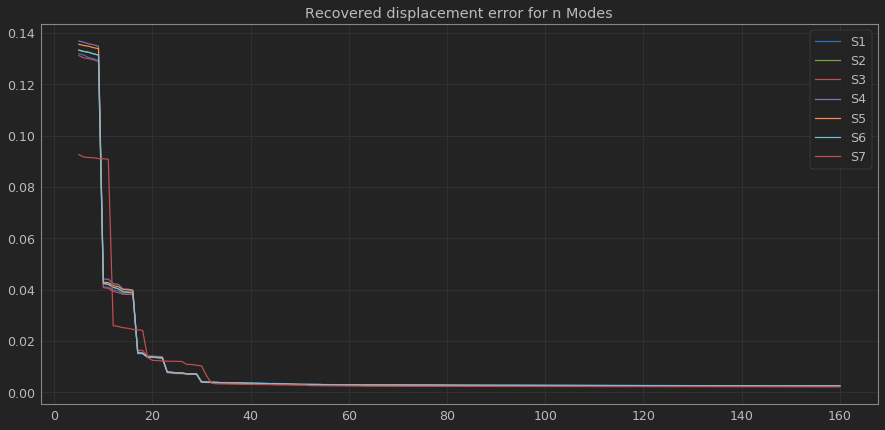

In [4]:
import matplotlib.pyplot as plt
try:
    from jupyterthemes import jtplot
    jtplot.style()
except:
    pass

plt.figure(figsize = (15,7))
plt.title('Recovered displacement error for n Modes')
range_ = range(5, 161, 1)
sz = len(list(range_))

x = list(range_)
for seg in range(7):
    if seg == 6:
        ax = plt.plot(x,scores_mem[seg,:], label = 'S'+str(seg+1), c = 'r')
    else:
        plt.plot(list(range_),scores_mem[seg,:], label = 'S'+str(seg+1))

plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (15,7))
plt.title('Recovered displacement error for n Bending Modes')
range_ = range(5, 161, 1)
sz = len(list(range_))

start_bm = 30
x = list(range_)
for seg in range(7):
    if seg == 6:
        ax = plt.plot(x[start_bm:],scores_mem[seg,start_bm:], label = 'S'+str(seg+1), c = 'r')
    else:
        plt.plot(x[start_bm:],scores_mem[seg,start_bm:], label = 'S'+str(seg+1))

plt.legend()
plt.show()